In [1]:
import splat
import wisps
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib as mpl
#matplotlib defaults
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 18
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'large'



%matplotlib inline

In [2]:
#plot mag vs 
obs=pd.read_csv(wisps.OUTPUT_FILES+'/observation_log.csv')
obs.columns=[x.lower() for x in obs.columns]#.lower()
def add_survey(pointing):
    if pointing.startswith('par'):
        return 'wisps'
    else:
        return '3d-hst'
obs_df=obs.drop(['unnamed: 0'], axis=1).drop_duplicates('pointing').reset_index()
obs_df['survey']=obs.pointing.apply(add_survey)

In [3]:
obs_df=obs_df.drop(['index'], axis=1)

In [4]:
#obs_df.to_latex(wisps.LIBRARIES+'/observations.tex', longtable=True, index=False)

In [5]:
phot=pd.read_hdf(wisps.COMBINED_PHOTO_SPECTRO_FILE, key='all_phot_spec_data')
fphot=wisps.Annotator.reformat_table(phot)

In [6]:
cutphot=fphot[((fphot.snr1>=3.0))]

In [7]:
import astropy.stats.bayesian_blocks as bb

In [8]:
edgesf160 =bb(cutphot.F160.replace(np.inf, np.nan).dropna(), fitness='events', p0=0.01)
edges140= bb(cutphot.F140.replace(np.inf, np.nan).dropna(), fitness='events', p0=0.01)
edges110= bb(cutphot.F110.replace(np.inf, np.nan).dropna(), fitness='events', p0=0.01)

In [9]:
#edges110

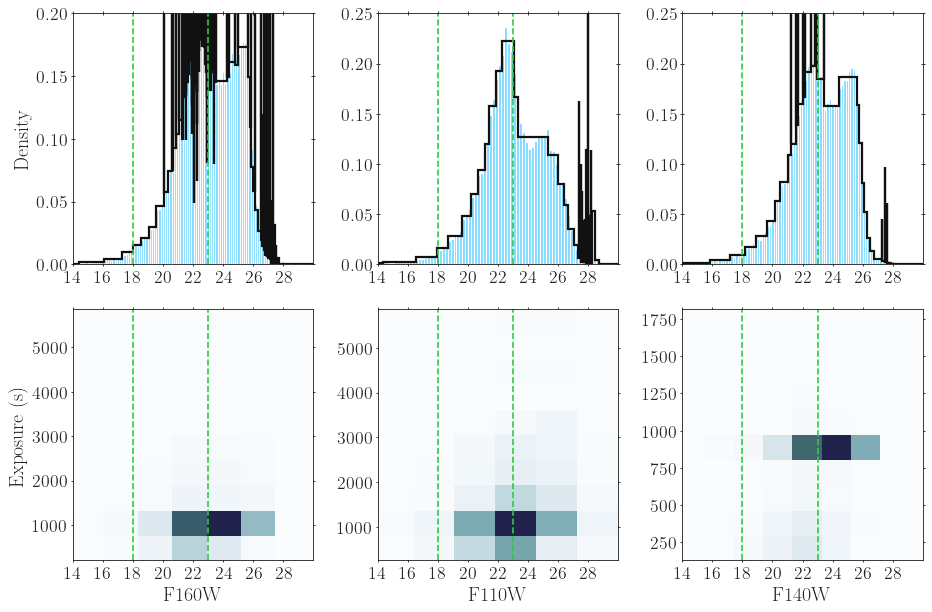

In [10]:
fig, ax=plt.subplots(ncols=3, nrows=2, figsize=(6*2, 4*2))
##top
h=ax[0][0].hist(cutphot.F160.dropna().values,  label='F160', bins='auto', color='#7FDBFF', density=True)
h=ax[0][1].hist(cutphot.F110.dropna().values,  label='F160', bins='auto', color='#7FDBFF', density=True)
h=ax[0][2].hist(cutphot.F140.replace(np.inf, np.nan).dropna().values,  label='F160', bins='auto', color='#7FDBFF', density=True)
#h=cutphot.F140.replace(np.inf, np.nan).dropna().plot(kind='hist', ax=ax[0][2], bins='auto',label='F140', color='#7FDBFF', density=True)

#bayesian blocks
H2 = ax[0][0].hist(cutphot.F160.replace(np.inf, np.nan).dropna(), bins=edgesf160, color='#111111',  density=True, lw =2, histtype='step')
H2 = ax[0][1].hist(cutphot.F110.replace(np.inf, np.nan).dropna(), bins=edges110, color='#111111',  density=True, lw =2, histtype='step')
H2 =ax[0][2].hist(cutphot.F140.replace(np.inf, np.nan).dropna(), bins=edges140, color='#111111',  density=True, lw =2, histtype='step')

ax[0][0].axvline(23, color='#2ECC40', linestyle='--')
ax[0][1].axvline(23, color='#2ECC40', linestyle='--')
ax[0][2].axvline(23, color='#2ECC40',linestyle='--')

ax[1][0].axvline(23, color='#2ECC40',linestyle='--')
ax[1][1].axvline(23, color='#2ECC40', linestyle='--')
ax[1][2].axvline(23, color='#2ECC40',linestyle='--')

ax[0][0].axvline(18.0, color='#2ECC40', linestyle='--')
ax[0][1].axvline(18.0, color='#2ECC40', linestyle='--')
ax[0][2].axvline(18.0, color='#2ECC40', linestyle='--')

ax[1][0].axvline(18.0, color='#2ECC40', linestyle='--')
ax[1][1].axvline(18.0, color='#2ECC40', linestyle='--')
ax[1][2].axvline(18.0, color='#2ECC40', linestyle='--')




#ax[1][0].scatter( cutphot.F160, cutphot.exposure, marker=',', alpha=0.1, s=50)
#sns.kdeplot( cutphot.F160, cutphot.exposure, ax=ax[1][0])
df=cutphot[['F160', 'exposure']].replace(np.inf, np.nan).dropna()
ax[1][0].hist2d(df.F160.values, df.exposure.values, cmap=wisps.MYCOLORMAP)

df=cutphot[['F110', 'exposure']].replace(np.inf, np.nan).dropna()
ax[1][1].hist2d(df.F110.values, df.exposure.values, cmap=wisps.MYCOLORMAP)

df=cutphot[['F140', 'exposure']].replace(np.inf, np.nan).dropna()
ax[1][2].hist2d(df.F140.values, df.exposure.values, cmap=wisps.MYCOLORMAP)

#sns.kdeplot( df.F160, df.exposure, ax=ax[1][0], shade=True)
#ax[1][1].scatter( cutphot.F110, cutphot.exposure, marker=',', alpha=0.1, s=50)
#ax[1][2].scatter( cutphot.F140, cutphot.exposure, marker=',', alpha=0.1, s=50)



ax[1][0].set_xlabel('F160W', fontsize=18)
ax[1][1].set_xlabel('F110W', fontsize=18)
ax[1][2].set_xlabel('F140W', fontsize=18)

ax[1][0].set_ylabel('Exposure (s)', fontsize=18)
ax[0][0].set_ylabel('Density', fontsize=18)
#ax[1][2].set_ylabel('Exposure (s)', fontsize=18)

for a in np.concatenate(ax):
    a.set_xticks(np.arange(14, 30, 2.0))
    a.set_xlim([14, 30])
    a.yaxis.set_ticks_position('both')
    a.xaxis.set_ticks_position('both')
    a.tick_params(which='major',direction='inout')
    a.tick_params(which='minor', direction='in')

ax[0][0].set_ylim([0., 0.20])
ax[0][1].set_ylim([0., 0.25])
ax[0][2].set_ylim([0., 0.25])
    
plt.tight_layout()

plt.savefig(wisps.OUTPUT_FIGURES+'/mag_limit.pdf')

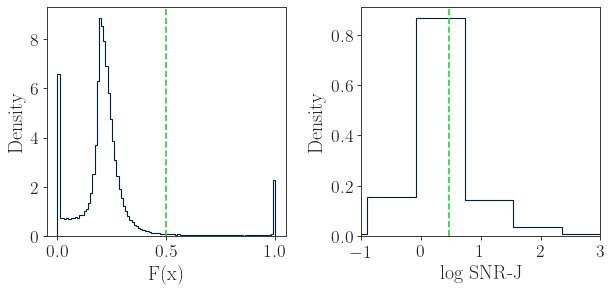

In [87]:
fig, (ax, ax1)=plt.subplots(figsize=(8, 4), ncols=2, sharey=False)
h=ax.hist(phot.f_test, bins=100, color='#001f3f', density=True, histtype='step')

ax.axvline(.5, color='#2ECC40', linestyle='--')
ax.set_xlabel('F(x)', fontsize=18)
ax.set_ylabel('Density', fontsize=18)


h=ax1.hist(phot.snr1.apply(np.log10), bins=100, color='#001f3f', density=True, histtype='step')

ax1.axvline(np.log10(3.), color='#2ECC40', linestyle='--')
ax1.set_xlabel('log SNR-J', fontsize=18)
ax1.set_ylabel('Density', fontsize=18)
ax1.set_xlim([-1., 3.])
plt.tight_layout()

plt.savefig(wisps.OUTPUT_FIGURES+'/f_test_snr_distr.pdf')

In [1]:
import wisps

In [8]:
import numpy as np

In [4]:
import splat

In [2]:
df=wisps.datasets['candidates']

In [5]:
vals=df.spt.apply(splat.typeToNum).values

In [9]:
ldwarfs=wisps.Annotator.reformat_table(df[np.logical_and(vals>=20.0, vals<30.)])

In [129]:
#ldwarfs.grism_id

In [16]:
s=wisps.Source(name='uds-25-G141_36758')

In [20]:
#s.plot()

In [19]:
s.snr

{'snr1': 30.676230626262367,
 'snr2': 24.470628099493492,
 'cdf_snr': 229.43633432168502,
 'snr3': 23.203291401640886,
 'snr4': 23.54791059768941}

In [131]:
ldwarfs[['grism_id', 'spt']]

,grism_id,spt
0,par338-00035,L1.0
1,par27-00036,L1.0
2,par444-00034,L0.0
3,par65-00035,L1.0
4,par199-00009,L1.0
5,par156-00041,L4.0
6,par21-00005,L1.0
7,par438-00051,L4.0
8,par106-00047,L8.0
9,uds-25-G141_36758,L1.0


In [137]:
ldwarfs.columns

Index(['Unnamed: 0', 'snr1', 'snr2', 'cdf_snr', 'snr3', 'snr4',
       'H_2O-1/J-Cont', 'H_2O-2/H_2O-1', 'H-cont/H_2O-1', 'CH_4/H_2O-1',
       'H_2O-2/J-Cont', 'H-cont/J-Cont', 'CH_4/J-Cont', 'H-cont/H_2O-2',
       'CH_4/H_2O-2', 'CH_4/H-Cont', 'grism_id', 'spex_chi', 'line_chi', 'spt',
       'F110', 'F140', 'F160', 'RA', 'DEC', 'survey', 'flags', 'x', 'f_test',
       'pointing', 'exposure'],
      dtype='object')